## TODO: Tutorial name
This is a tutorial showcasing the functionality of cooper in the context of a convex constrained optimization problem.

It is inspired by Engraved Blogpost

### Setup
Install cooper.

In [ ]:
!pip install git+https://github.com/gallego-posada/cooper
# TODO: .[examples], try from scratch
# !python setup.py install torch_cooper

In [10]:
import numpy as np

import matplotlib.pyplot as plt
import torch
import cooper
from copy import deepcopy as copy
from collections import OrderedDict

### Constrained Minimization Problem

Cooper supports constrained minimization problems with the following form:
\begin{align}
    & \underset{x}{\text{min}}\, & f(x) \tag{1} \\
    & \text{s.t.} & g(x) \leq 0 \\
    & & h(x) = 0
\end{align}

In this tutorial, we consider the following constrained optimization problem on
 the 2D domain $(x, y) \in [0,\pi/2] \times [0,\infty]$

\begin{align*}
\underset{x, y}{\text{min}}\quad f(x,y) &:= \left(1 - \text{sin}(x) \right) \ \big(1+y^2\big) & \tag{2} \\

s.t. \quad  g(x,y) &:= \left(1 - \text{cos}(x) \right)\ \big(1+y^2\big) - \epsilon \leq 0 & \\

\end{align*}

given some $\epsilon \geq 0 $.
Note how both $f$ and $g$ are convex functions in the specified domain.
As such, this constrained minimization problem is a convex problem.

In [194]:
# Define a Constrained Minimization Problem. This object holds a state,
# containing the current values of the loss (f), inequality constraint defects (g),
# and equality constraint defects (h).


class Convex2dCMP(cooper.ConstrainedMinimizationProblem):
    def __init__(self, is_constrained=False, epsilon=1.0):
        self.epsilon = epsilon
        super().__init__(is_constrained)

    def closure(self, params):
        """This function evaluates the objective function and constraint
        defect. It updates the attributes of this CMP based on the results."""

        x = params[:, 0]
        y = params[:, 1]

        # assert x >= 0 and x <= np.pi / 2
        # assert y >= 0

        f = (1 - torch.sin(x)) * (1 + y**2)
        g = (1 - torch.cos(x)) * (1 + y**2)

        # Define the constraint defects
        _ineq_defect = g - self.epsilon  # in standard form (defect <= 0)
        _eq_defect = None  # no equality constraints

        # Store the values in a CMPState as attributes
        state = cooper.CMPState(
            loss=f,
            eq_defect=_eq_defect,
            ineq_defect=_ineq_defect,
            # other information can be stored in the misc dictionary. cooper
            # will not access misc and does not require it.
            misc={'g': g.data},
            )

        return state

In [195]:
# Initialize the ConvexCMP.
EPSILON = 0.4
cmp = Convex2dCMP(is_constrained=True, epsilon=EPSILON)

# cmp.state is currently None, as we have not populated it yet.
print(cmp.state)

None


There are many ways to solve problems formulated as Eq. (1). In particular,
given our choice of problem in Eq. (2), we have convergence guarantees if we
employ this or that to solve it. can

Let us check the solution



### Formulation

Cooper has been designed to be used on neural network training in Pytorch.
As such, we use the Lagrangian formulation of Eq. (2) and optimize its respective
min-max game:

\begin{align*}
& \underset{x, y}{\text{min}}\ \underset{\lambda \geq 0}{\text{max}}\ f(x,y) +
\lambda g(x,y) \tag{3} \\
& \underset{x, y}{\text{min}}\ \underset{\lambda \geq 0}{\text{max}}\,
\big(1 - \text{sin}(x) \big) \ \big(1+y^2\big) +
\lambda \big(1 - \text{cos}(x) \big)\ \big(1+y^2\big)  \\

\end{align*}

Now we setup a Lagrangian formulation for ConstrainedMinimizationProblem `cmp`

In [414]:
# By default, multipliers are initialized to zero. Otherwise, we could provide
# ineq_init or eq_init for
formulation = cooper.LagrangianFormulation(cmp, ineq_init=None, eq_init=None)

# Lambda is held inside the formulation object.
multipliers = formulation.dual_parameters
print(multipliers)

[]


### Optimizer

Now, construct the optimizer
Lagrangian via gradient descent ascent schemes.
Compatible with any torch optimizer on the primal and dual


In [415]:
params = torch.nn.Parameter(torch.tensor([[0.25, 1.5]]))

In [416]:
# Wrapper around torch optimizers
primal_optimizer = cooper.optim.SGD([params], lr=5e-3, momentum=0.0)
# Dual variables are initialized internally by the formulation when the shape
# of defects is identified. We provide a partial initializariion of the dual optim
dual_optimizer = cooper.optim.partial(cooper.optim.SGD, lr=5e-3)

# Initialize the constrained optimizer, which handles internally updates of the
# primal and dual variables.
constrained_optimizer = cooper.ConstrainedOptimizer(
    formulation=formulation,
    primal_optimizer=primal_optimizer,
    dual_optimizer=dual_optimizer
)

### Training loop

The training loop is very similar to a vanilla pytorch loop

In [417]:
# Store CMPStates and parameter values throughout the optimization process

state_history = OrderedDict()

state_history[0] = {
            "cmp": cmp.state,
            "dual": copy(torch.tensor([[0.]])),
            "params": copy(params.data)
            }

for iter in range(1, 2000 + 1):
    # Zero the gradients wrt the parameters and multipliers
    constrained_optimizer.zero_grad()

    # Calculate the lagrangian.
    lagrangian = formulation.composite_objective(
        cmp.closure, # forward-like function, computing loss and defects
        params=params, # args and kwargs required for closure
        )

    # Backward
    formulation.custom_backward(lagrangian)

    # Step
    constrained_optimizer.step()

    # Clip parameters
    params[:, 0].data.clamp_(min=0, max=np.pi/2)
    params[:, 1].data.clamp_(min=0)
    
    state_history[iter] = {
            "cmp": cmp.state,
            "dual": copy(formulation.state()),
            "params": copy(params.data)
            }


In [418]:
iters, loss_hist = zip(
    *[(iter_num, _["cmp"].loss.item()) for (iter_num, _) in state_history.items()]
)

params_hist = np.stack(
    [_["params"].data.numpy() for (foo, _) in state_history.items()], axis=1
).squeeze()

mult_hist = np.stack(
    [_["dual"][0].data.numpy() for (foo, _) in state_history.items()], axis=1
)

defect_hist = np.stack(
    [_["cmp"].ineq_defect.data.numpy() for (foo, _) in state_history.items()], axis=1)

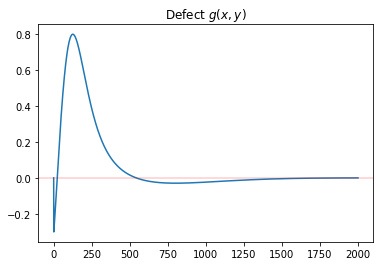

In [419]:
plt.plot(iters, defect_hist.squeeze())
plt.axhline(0.0, c="r", alpha=0.2)
plt.title(r"Defect $g(x,y)$")
plt.show()

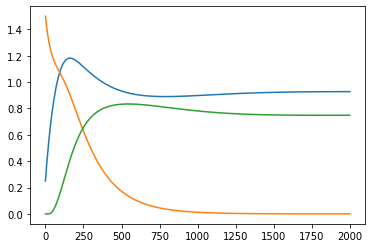

In [420]:
plt.plot(iters, params_hist)
plt.plot(iters, mult_hist.squeeze())
plt.show()

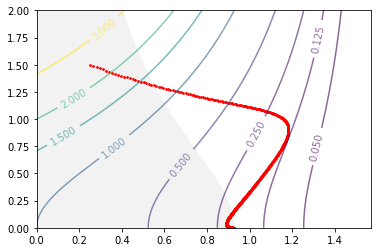

In [421]:
x_range = torch.tensor(np.linspace(0, np.pi/2, 100))
y_range = torch.tensor(np.linspace(0, 2., 100))
grid_x, grid_y = torch.meshgrid(x_range, y_range, indexing='ij')

grid_params = torch.stack([grid_x.flatten(), grid_y.flatten()], axis=1)
all_states = cmp.closure(grid_params)

fig, ax = plt.subplots()
CS = ax.contour(grid_x, grid_y, all_states.loss.reshape(len(x_range), len(y_range)),
                [0.05, 0.125, 0.25, 0.5, 1, 1.5, 2., 3.], alpha=0.6)
ax.clabel(CS, inline=1, fontsize=10)

cg3 = ax.contourf(grid_x, grid_y, all_states.ineq_defect.reshape(len(x_range), len(y_range)),
                 [-10, 0], colors='gray', alpha=0.1)

plt.scatter(*params_hist.T, s=3, c='red')
# plt.ylim(-0.02, 1.02)
# plt.xlim(-0.02, np.pi/2 + 2e-2)


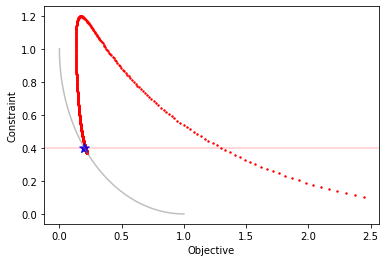

In [422]:
# Theoretical boundary
x_range = torch.tensor(np.linspace(0, np.pi/2, 100))
y_range = torch.tensor(100*[0.])
all_states = cmp.closure(torch.stack([x_range, y_range], axis=1))
plt.plot(all_states.loss, EPSILON + all_states.ineq_defect.squeeze(), c='gray', alpha=0.5)

# Achieved trajectory
plt.scatter(loss_hist, EPSILON + defect_hist.squeeze(), s=2, c='red')
plt.scatter(loss_hist[-1], EPSILON + defect_hist.squeeze()[-1], marker="*", s=100, c='blue')
plt.axhline(EPSILON, c="r", alpha=0.2)
plt.xlabel("Objective")
plt.ylabel("Constraint")
plt.show()

## Training dynamics

TODO:
- grid of plots for these initial 3
- hline for optimal solution
- ipywidgets
- move bulk to plot_helpers.py


In [ ]:
iters_array = np.array([0, *iters])

In [ ]:
plt.plot(iters_array, loss_history)
plt.title("Loss")

In [ ]:
plt.plot(iters_array, g_history)
plt.axhline(EPSILON, color='r', linestyle='--')
plt.title(r"$g(x,y)$")

In [ ]:
plt.plot(iters_array, multiplier_history)


# Fancier visualizations
- Parameters in param space with level curves
- f vs g